In [1]:
import networkx as nx
from matplotlib import pyplot as plt
import random
import math
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
def distance(x1, y1, x2, y2):
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5
def contact_prob(distance, contact_density,x1, y1, x2, y2):
    d = distance(x1, y1, x2, y2)
    return math.exp(-d/contact_density)

In [3]:
def initialize_graph(node_count, distance = distance, contact_density = 1):
    square_size = math.sqrt(node_count) #size of square
    custom_pos = {} #custom position for plotting
    G = nx.Graph()
    for i in range(node_count):
        G.add_node(i)
    #initialize node state, color, and position
    #set the colors
    #S = susceptible (green)
    #I = infected (red)
    #R = recovered (blue)
    for node in G.nodes():
        G.nodes[node]['state'] = 'S'  
        x,y = random.uniform(0, square_size), random.uniform(0, square_size)
        G.nodes[node]['pos'] = (x,y)
        G.nodes[node]['observed'] = False
        G.nodes[node]['SIR_prob'] = [1,0,0]
        custom_pos[node] = (x,y)
    #set the edges
    for x in range(node_count):
        for y in range(x+1, node_count):
            if contact_prob(distance, contact_density, G.nodes[x]['pos'][0], G.nodes[x]['pos'][1], G.nodes[y]['pos'][0], G.nodes[y]['pos'][1]) > random.uniform(0, 1):
                G.add_edge(x,y)
    return G, custom_pos

In [4]:
def infectRandomNode(G):
    #infect a random node that is susceptible
    node_list = list(G.nodes())
    random.shuffle(node_list)
    for node in node_list:
        if G.nodes[node]['state'] == 'S':
            G.nodes[node]['state'] = 'I'
            G.nodes[node]['SIR_prob'] = [0,1,0]
            break

In [5]:
def update(G, infection_rate, recovery_rate):
    #infect susceptible nodes that are in contact with infected nodes
    new_G = G.copy()
    for node in G.nodes():
        if G.nodes[node]['state'] == 'S':
            for neighbor in G.neighbors(node):
                if G.nodes[neighbor]['state'] == 'I':
                    if random.uniform(0, 1) < infection_rate:
                        new_G.nodes[node]['state'] = 'I'
                        break
        elif G.nodes[node]['state'] == 'I':
            if random.uniform(0, 1) < recovery_rate:
                new_G.nodes[node]['state'] = 'R'
    return new_G
        


In [6]:
def SurroundInfectionRate(graph, node, infection_rate):
    neighbors = list(graph.neighbors(node))
    result = 0
    for neighbor in neighbors:
        result += infection_rate * graph.nodes[neighbor]['SIR_prob'][1]
    return result

In [7]:
def MeanFieldInference(graph_t, infection_rate, recovery_rate):
    predicted_state_t1 = {}
    for node in graph_t.nodes():
        factor = SurroundInfectionRate(graph_t, node, infection_rate)
        Ps = graph_t.nodes[node]['SIR_prob'][0]*(1-factor)
        Pi = (1-recovery_rate)*graph_t.nodes[node]['SIR_prob'][1] + graph_t.nodes[node]['SIR_prob'][0]*factor
        Pr = graph_t.nodes[node]['SIR_prob'][2] + recovery_rate*graph_t.nodes[node]['SIR_prob'][1]
        predicted_state_t1[node] = [Ps, Pi, Pr]
    return predicted_state_t1


In [8]:
def BackloopUpdate(temporal_graphs,t ,delta, node, state):
    mapper = {'S':[1,0,0], 'I':[0,1,0], 'R':[0,0,1]}
    for i in range(t, t-delta-1, -1):
        temporal_graphs[i].nodes[node]['SIR_prob'] = mapper[state]
        temporal_graphs[i].nodes[node]['observed'] = True
    

In [9]:
#@param: give a list of nodes that are observed
def DetectObserve(obs, temporal_graphs, t, delta):
    for entry in obs:
        state = temporal_graphs[t].nodes[entry[0]]['state']
        if state == 'S':
            BackloopUpdate(temporal_graphs, t, delta, entry[0], 'S')
        elif state == 'I':
            BackloopUpdate(temporal_graphs, t, delta, entry[0], 'I')
        elif state == 'R':
            BackloopUpdate(temporal_graphs, t, delta, entry[0], 'R')

In [10]:
def SetRemove(graph, nodes):
    for entry in nodes:
        graph.nodes[entry[0]]['observed'] = True
        graph.nodes[entry[0]]['SIR_prob'] = [0,0,1]
        graph.nodes[entry[0]]['state'] = 'R'

In [11]:
def SIR_count(graph):
    S_count = 0
    I_count = 0
    R_count = 0
    for node in graph.nodes():
        if graph.nodes[node]['state'] == 'S':
            S_count += 1
        elif graph.nodes[node]['state'] == 'I':
            I_count += 1
        elif graph.nodes[node]['state'] == 'R':
            R_count += 1
    return S_count, I_count, R_count

In [47]:
mode = 'R' #'MF', 'R', 'None'
node_count = 100
infection_rate = 0.1
recovery_rate = 0.1
contact_density = 1
time_steps = 50
temporal_graph_dict = {}
observe_per_day = 2
t_mf = 3
color_map = {'S': 'green', 'I': 'red', 'R': 'blue'}
def sim(DataFrame, id):
    graph, custom_pos = initialize_graph(node_count, distance, contact_density)
    infectRandomNode(graph)
    temporal_graph_dict[0] = graph.copy()
    S, I, R = SIR_count(graph)
    DataFrame.loc[len(DataFrame)] = [id, 0, S, I, R]
    for i in range(1, time_steps):
        graph = update(temporal_graph_dict[i-1], infection_rate, recovery_rate)
        temporal_graph_dict[i] = graph.copy()
        if (mode == 'MF' and i > 10):
            pred = MeanFieldInference(graph, infection_rate, recovery_rate)
            sort_pred = sorted(pred.items(), key=lambda x: x[1])
            DetectObserve(sort_pred[:observe_per_day], temporal_graph_dict, i, t_mf)
            SetRemove(temporal_graph_dict[i], sort_pred[:observe_per_day])
        S, I, R = SIR_count(graph)
        DataFrame.loc[len(DataFrame)] = [id, i, S, I, R]
    return temporal_graph_dict, custom_pos
    

In [48]:
experiment_df = pd.DataFrame(columns=['id', 'time', 'S', 'I', 'R'])
experiment_df

,id,time,S,I,R


In [49]:
#temporal_graph, custom_pos = sim(experiment_df, 0)

In [50]:
for i in tqdm(range(0,100)):
    temporal_graph, custom_pos = sim(experiment_df, i)

  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: 'int' object is not subscriptable

In [36]:
experiment_df.to_csv('experiment_df_pure.csv')

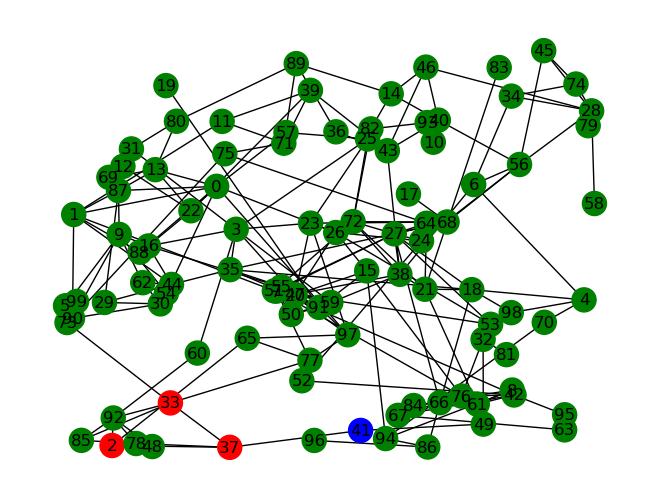

In [16]:
graph = temporal_graph_dict[4]
colors = [color_map[graph.nodes[node]['state']] for node in graph.nodes()]
nx.draw(graph, pos = custom_pos, node_color = colors, with_labels = True)

In [17]:
def drawgraph(graph, custom_pos, t):
    graph = temporal_graph_dict[t]
    colors = [color_map[graph.nodes[node]['state']] for node in graph.nodes()]
    nx.draw(graph, pos = custom_pos, node_color = colors, with_labels = True)

In [18]:
from ipywidgets import *
interact(drawgraph, graph = fixed(temporal_graph_dict), custom_pos = fixed(custom_pos), t = widgets.IntSlider(min=0, max=time_steps-1, step=1, value=0))


interactive(children=(IntSlider(value=0, description='t', max=49), Output()), _dom_classes=('widget-interact',…

<function __main__.drawgraph(graph, custom_pos, t)>

In [37]:
experiment_df['S'] = experiment_df['S'].apply(lambda x: x/node_count)
experiment_df['I'] = experiment_df['I'].apply(lambda x: x/node_count)
experiment_df['R'] = experiment_df['R'].apply(lambda x: x/node_count)

In [38]:
result = experiment_df.groupby('time').mean()

In [41]:
MF_result = pd.read_csv('experiment_df.csv')

In [44]:
MF_result['I'] = MF_result['I'].apply(lambda x: x/node_count)
mf_result = MF_result.groupby('time').mean()

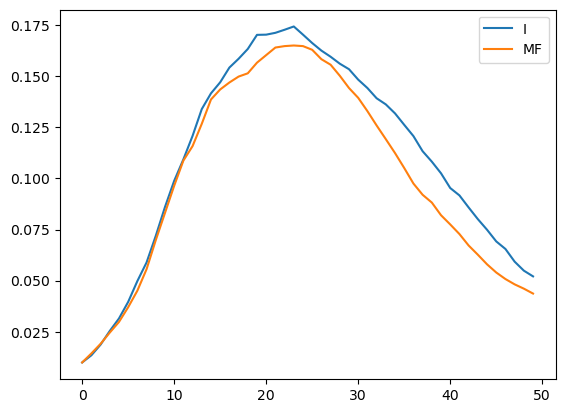

In [46]:
plt.plot(result['I'], label = 'I')
plt.plot(mf_result['I'], label = 'MF')
plt.legend()